In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
#from tensorflow.data import Dataset as tfds
from tensorflow.keras.utils import plot_model
import IPython
#import helper_gan

tf.compat.v1.reset_default_graph()
#import tensorflow.datasets as tfds
%matplotlib inline

In [2]:
dataset_dir = "D:/dataset/celebA/"
#類別數量
n_class = 2
#圖片尺寸
img_size = (64, 64)
width = 64

batch_size = 32
latent_dim = 100

In [3]:
#資料集存取路徑
path='D:/dataset/celebA/img_align_celeba/'
img_list=[]
all_labels = []


In [4]:
#資料準備，讀取圖片
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            filename = os.path.join(root, file)
            file_size = os.path.getsize(filename)
            category_name = os.path.basename(root)
            #y_Train.append(dict_label[category_name])
            im = Image.open(filename)
            im = im.resize(img_size,Image.BILINEAR)
            im = im.convert("RGB")
            imarray = np.array(im)
            img_list.append(imarray)

In [5]:
all_digits = np.asarray(img_list)

In [6]:
#get labels value
attr_fn = dataset_dir+'list_attr_celeba.txt'
with open(attr_fn, 'r') as f:
    # parse number of data
    first_line = f.readline()

    # parse each attribute names & size
    second_line = f.readline()
    attr_names = second_line.split()
    n_attr = len(attr_names)

    # get index of attribute
    attr_index = attr_names.index('Male')

# load whole text file as in np ndarray(2d matrix: n_data x n_attr)
attr_data = np.loadtxt(attr_fn, dtype=int, skiprows=2, usecols=range(1, n_attr + 1))

all_labels = attr_data[:, attr_index]

In [7]:
#印出10張圖片的function
def display(array1):
    n = 10

    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(array1[i].reshape(width, width, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [8]:
print(all_digits.shape)
print(all_labels.shape)

(202599, 64, 64, 3)
(202599,)


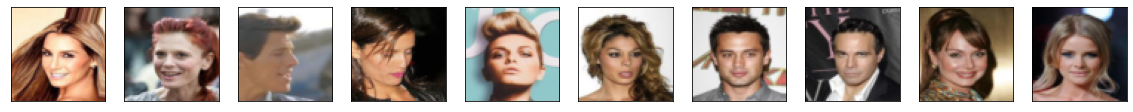

In [9]:
display(all_digits)

In [ ]:
# Scale the pixel values to [-1, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 127.5 - 1
#all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, width, width, 3))
all_labels = keras.utils.to_categorical(all_labels, n_class)

In [ ]:
# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

In [ ]:
#定義generator
# label input
con_label = keras.Input(shape=(n_class,))

# latent vector input
latent_vector = keras.Input(shape=(100,))

In [ ]:
# define the final generator model
def define_generator():
    featuremap_size = 512
    alpha = 0.2
    #concatenate inputs
    merge = layers.Concatenate(axis=1)([latent_vector, con_label])

    #Fully connected layer & reshape to prepare first layer
    nodes = 4 * 4 * featuremap_size
    gfc = layers.Dense(nodes, use_bias=True)(merge)

    greshape = layers.Reshape((4, 4, featuremap_size))(gfc)
    gbn = layers.BatchNormalization()(greshape)
    gx = layers.LeakyReLU(alpha)(gbn)

    featuremap_size = featuremap_size // 2
    x = layers.Conv2DTranspose(featuremap_size, kernel_size=5, strides=2, padding='same')(gx)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha)(x)
    
    featuremap_size = featuremap_size // 2
    x = layers.Conv2DTranspose(featuremap_size, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha)(x)
    
    featuremap_size = featuremap_size // 2
    x = layers.Conv2DTranspose(featuremap_size, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha)(x)
    
    out_layer = layers.Conv2DTranspose(3, kernel_size=5, strides=2,padding='same', activation='tanh')(x)
    
   # define model
    model = keras.Model([con_label, latent_vector], out_layer)
    return model

In [ ]:
conditional_gen = define_generator()

In [ ]:
conditional_gen.summary()

In [ ]:
plot_model(conditional_gen, to_file='generator_Model.png', show_shapes=True)

IPython.display.Image('generator_Model.png')

In [ ]:
#定義discriminator
# label input
con_label2 = layers.Input(shape=(64,64,n_class))

# input image
inp_img = layers.Input(shape=(64,64,3))

In [ ]:
def define_discriminator():
    filters = 64
    alpha = 0.2
    # concat label as a channel
    merged = layers.Concatenate(axis=3)([inp_img, con_label2])
    
    x = layers.Conv2D(filters, kernel_size=5, strides= 2, padding='same')(merged)
    x = layers.LeakyReLU(alpha)(x)
    
    filters = filters * 2
    x = layers.Conv2D(filters, kernel_size=5, strides= 2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha)(x)
    
    filters = filters * 2
    x = layers.Conv2D(filters, kernel_size=5, strides= 2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha)(x)
    
    filters = filters * 2
    x = layers.Conv2D(filters, kernel_size=5, strides= 2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha)(x)
 
    flattened_out = layers.Flatten()(x)

    # output
    dense_out = layers.Dense(1, activation='sigmoid')(flattened_out)
    # define model


    # define model
    model = tf.keras.Model([inp_img, con_label2], dense_out)
    
    return model

In [ ]:
conditional_discriminator = define_discriminator()
conditional_discriminator.summary()

In [ ]:
plot_model(conditional_discriminator, to_file='disciminator_Model.png', show_shapes=True)

IPython.display.Image('disciminator_Model.png')

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

In [ ]:
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [ ]:
#define optimizer
generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5)

In [ ]:
conditional_gen.compile(loss=binary_cross_entropy, optimizer=generator_optimizer)
conditional_discriminator.compile(loss=binary_cross_entropy, optimizer=discriminator_optimizer)

In [ ]:
# reshape y into appropriate input to D
def y_reshaper(y, width, height):
    new_y = np.zeros((y.shape[0], width, height, y.shape[1]))
    
    for i in range(y.shape[0]):
        new_y[i, :, :, :] = y[i,:] * np.ones((width, height, y.shape[1]))
    return new_y

In [ ]:
#隨機產產生20張圖片的function
def generate_images():
    #隨機產生noise
    glabels = np.zeros(20)
    for i in range(20):
        if i%10==0:
            glabels[i]=0
        if i%10==1:
            glabels[i]=1
        
            
    glabels = keras.utils.to_categorical(glabels, n_class)

    #產生圖片
    noise = tf.random.normal([20, latent_dim])
    generated_images = (conditional_gen([glabels,noise]))

    #將generated_images值縮為0-1
    generated_images = (generated_images + 1) / 2

    return generated_images

In [ ]:
#印出20張圖片的function
def display_3class(array1, savepath):
    n = 10

    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(array1[i])
        plt.title('male')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(array1[i+10])
        plt.title('female')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        
    plt.gcf()
    plt.savefig(savepath)    
    plt.show()

In [ ]:
#畫出loss圖
def plot_loss(d_loss, g_loss, savepath):
    plt.plot(d_loss, label='d_loss')
    plt.plot(g_loss, label='g_loss', linestyle='--')
    plt.legend()
    plt.grid()
    #plt.xticks(range(0, epoch, int(epoch/10)))
    plt.title('loss history')
    plt.ylabel('loss value')
    plt.xlabel('iteration')
    plt.gcf()
    plt.savefig(savepath)
    plt.show()

In [ ]:
#用於儲存d和g的loss
d1_loss = 0
d2_loss = 0
dfake_loss = []
dreal_loss = []
d_loss = []
g_loss = []

#define train_step
# Notice the use of `tf.function`. This annotation causes the function to be "compiled".
@tf.function(tf.config.run_functions_eagerly(True))
def train_step(images,target):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([target.shape[0], latent_dim])
    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = conditional_gen([target,noise], training=True)

        target_disc = y_reshaper(target, width, width)
        real_output = conditional_discriminator([images,target_disc], training=True)
        real_targets = tf.ones_like(real_output)
        
        #label smooth
        #real_targets = real_targets - 0.1
        
        disc_loss1 = discriminator_loss(real_targets, real_output)
        d1_loss = disc_loss1.numpy()
        dreal_loss.append(d1_loss)
        
    # gradient calculation for discriminator for real labels    
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, conditional_discriminator.trainable_variables)
    
    # parameters optimization for discriminator for real labels   
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    conditional_discriminator.trainable_variables))
    
    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = conditional_discriminator([generated_images,target_disc], training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
        d2_loss = disc_loss2.numpy()
        dfake_loss.append(d2_loss)
        
    #
    d_loss.append(d1_loss + d2_loss)
    
    # gradient calculation for discriminator for fake labels 
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, conditional_discriminator.trainable_variables)
    
    
    # parameters optimization for discriminator for fake labels        
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    conditional_discriminator.trainable_variables))
    
    
    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = conditional_gen([target,noise], training=True)
        fake_output = conditional_discriminator([generated_images,target_disc], training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)
        g_loss.append(gen_loss.numpy())

    # gradient calculation for generator for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, conditional_gen.trainable_variables)
    
    
    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    conditional_gen.trainable_variables))  
    
    
    #print("g_loss: {gen_loss}, d_loss: {disc_total_loss}")

In [ ]:
#train
import time
def train(dataset, epochs):
    for epoch in range(epochs):
        iteration = 0
        start = time.time()
        for image_batch in dataset:
            img = tf.cast(image_batch[0], tf.float32)
            #imgs = normalization(img)
            imgs = img
            train_step(imgs, image_batch[1])
            print ('epoch {}, {}/{}, g_loss: {}, d_loss: {}, dreal_loss: {}, dfake_loss: {}'.format(epoch + 1, iteration+1, len(dataset), g_loss[-1], d_loss[-1], dreal_loss[-1], dfake_loss[-1]))
            iteration+=1
        
        if epoch%5==0 or epoch == epochs-1:
            epoch_imgs = generate_images()
            savepath =  "D:/gan_img/celeba//epoch_"+str(epoch)+"_face_generate.jpg" 
            display_3class(epoch_imgs, savepath)
        
        if epoch%50==0 or epoch == epochs-1:
            conditional_gen.save('D:/gan_img/celeba/h5/generator_'+str(epoch)+'.h5')
            conditional_discriminator.save('D:/gan_img/celeba/h5/discriminator_'+str(epoch)+'.h5')
            history_savepath = "D:/gan_img/celeba/h5/"+str(epoch)+"_history.jpg"
            plot_loss(d_loss, g_loss, history_savepath)
              
epoch = 150
train(dataset, epoch)

In [ ]:
"""
#取出每個epoch最後一個batch的loss
d_loss_epoch = []
g_loss_epoch = []

itern = len(dataset)
for i in range(epoch):
    n = ((i+1)*itern)-1
    d_loss_epoch.append(d_loss[n])
    g_loss_epoch.append(g_loss[n])
"""

In [ ]:
#畫出loss圖
plt.plot(d_loss, label='d_loss')
plt.plot(g_loss, label='g_loss', linestyle='--')
plt.legend()
plt.grid()
#plt.xticks(range(0, epoch, int(epoch/10)))
plt.title('loss history')
plt.ylabel('loss value')
plt.xlabel('iteration')
plt.gcf()
plt.savefig("D:/gan_img/celeba/h5/history.jpg")
plt.show()

In [ ]:
generated_images = generate_images()

In [ ]:
img_savepath = "D:/gan_img/celeba/face_generate.jpg"
display_3class(generated_images, img_savepath)